In [1]:
%load_ext autoreload
%autoreload 2

In [124]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from utils.pandas import apply_filters
from utils_local import read_spreadsheet, colors_v1, markers_v1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Domain-shift: Linear and Finetuning

In [157]:
from utils_local import load_domain_shift_results, scatter_with_correlation

In [158]:
k400_values, df_linear, df_finetune = load_domain_shift_results(remove_K400=True)

In [159]:
k400_values

{'Method': ['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 'linear': array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ])}

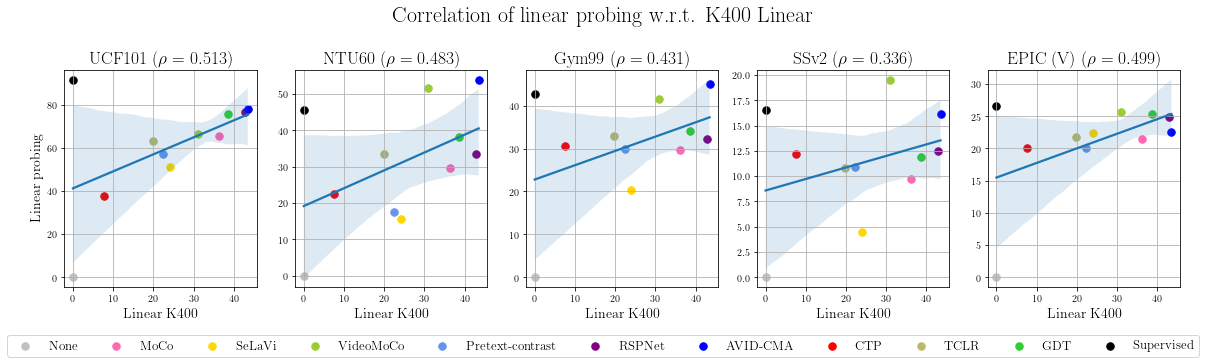

In [91]:
fig, axes = plt.subplots(1, len(df_linear.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_linear.columns[i]
    
    ylabel = "Linear probing" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of linear probing w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

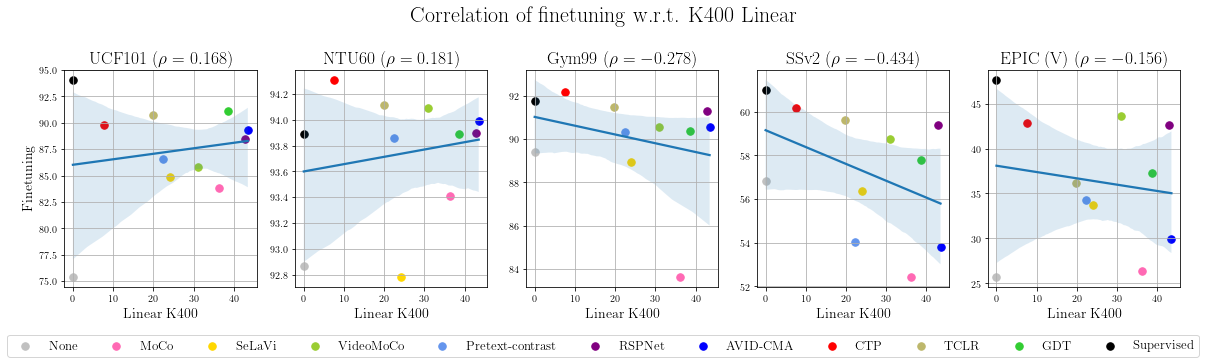

In [92]:
fig, axes = plt.subplots(1, len(df_finetune.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

### Domain-shift with varying training data size

In [93]:
df = read_spreadsheet(gid_key="dataset_size")
df.dropna(inplace=True)

In [94]:
dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

In [95]:
for d, v in dataset_full_size.items():
    indices = (df.Dataset == d) * (df["Dataset size"] == "Full")
    df.at[indices, "Dataset size (float)"] = v

In [96]:
df["Dataset size (float)"] = df["Dataset size (float)"].astype(float)

In [98]:
df_ucf = apply_filters(df, {"Dataset": "UCF"})

In [100]:
k400_values

{'linear': array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ])}

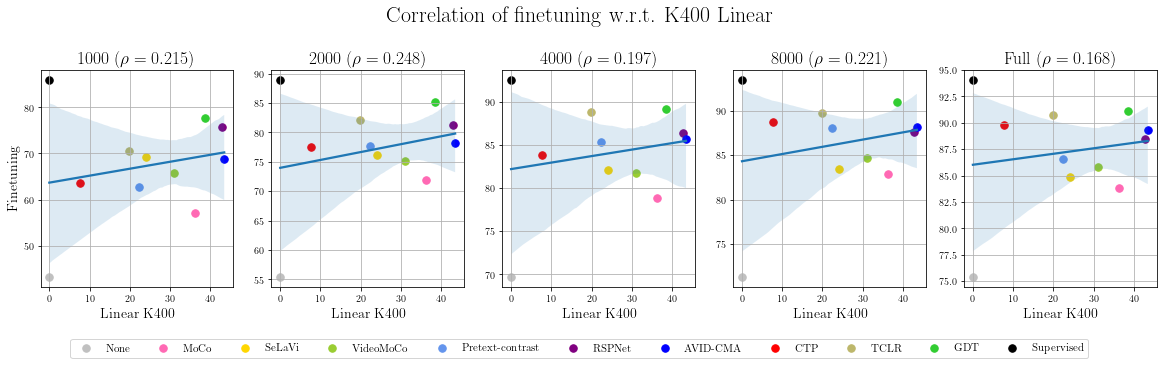

In [180]:
sizes = df_ucf["Dataset size"].unique()

fig, axes = plt.subplots(1, len(sizes), figsize=(20, 4))


for i, size in enumerate(sizes):
    sdf = apply_filters(df_ucf, {"Dataset size": size})

    # reorder based on UCF finetuning performance
    sdf = sdf.set_index("Method").rename(index={
        "No pretraining": "None",
        "Supervised pretraining": "Supervised",
        "SELAVI": "SeLaVi",
        "RSPNET": "RSPNet",
        "Video Moco": "VideoMoCo",
        "Pretext-Contrast": "Pretext-contrast",
    }).loc[np.array(k400_values["Method"])].reset_index()

    methods = sdf.Method.values

    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(methods),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=11,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=sdf["Top-1"].values,
        labels=methods,
        ax=ax,
        size_alpha=0.7,
        title=size,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()


plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

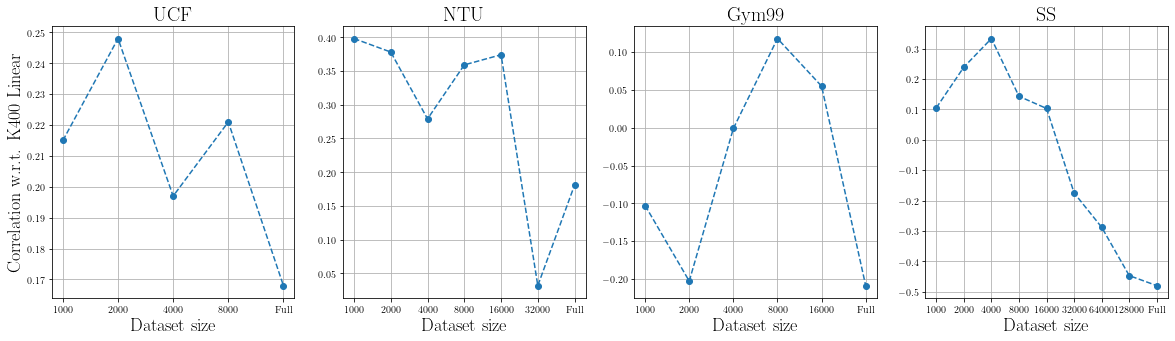

In [182]:
datasets = df.Dataset.unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5))


ax.grid()
ax.set_title("Correlation between K400 linear vs finetuning", fontsize=20)


for i, dataset in enumerate(datasets):
    
    ax = axes[i]

    sizes_to_plot = []
    correlations = []
    
    df_dataset = apply_filters(df, {"Dataset": dataset})
    sizes = df_dataset["Dataset size"].unique()


    xvalues = k400_values["linear"]
    for j, size in enumerate(sizes):
        sdf = apply_filters(df_dataset, {"Dataset size": size})
        # reorder based on UCF finetuning performance
        sdf = sdf.set_index("Method").rename(index={
            "No pretraining": "None",
            "Supervised pretraining": "Supervised",
            "SELAVI": "SeLaVi",
            "RSPNET": "RSPNet",
            "Video Moco": "VideoMoCo",
            "Pretext-Contrast": "Pretext-contrast",
        }).loc[np.array(k400_values["Method"])].reset_index()
        

        methods = sdf.Method.values

        yvalues = sdf["Top-1"].values

        corr = np.round(np.corrcoef(xvalues, yvalues)[0, 1], decimals=3)
        # corr = stats.spearmanr(xvalues, yvalues).correlation
        sizes_to_plot.append(size)
        correlations.append(corr)
    
    # ax.set_ylim(-0.5, 0.6)
    ax.plot(sizes_to_plot, correlations, "--o", label=dataset)
    ax.set_title(dataset, fontsize=20)
    ax.grid()
    ax.set_xlabel("Dataset size", fontsize=18)

    if i == 0:
        ax.set_ylabel("Correlation w.r.t. K400 Linear", fontsize=18)

plt.show()